In [1]:
from math import sqrt

import matplotlib.pyplot as plt
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F

plt.rc('font', family='serif')
plt.rc('text', usetex=True)


In [2]:
class AssMem(nn.Module):
    def __init__(self, d, n, m):
        """
        d: int
            Memory dimensionality
        n: int
            Number of input tokens
        m: int
            Number of classes
        """
        super().__init__()
        self.W = nn.Parameter(th.randn(d, d))
        # self.W = th.eye(d)
        self.E = nn.Parameter(th.randn(n, d) / sqrt(d))
        self.UT = nn.Parameter(th.randn(d, m) / sqrt(d))

    def forward(self, x):
        out = self.E[x] @ self.W
        out = out @ self.UT
        out = F.softmax(out, dim=-1)
        return out


def modular_class(x, m):
    return x % m

In [3]:
# number of input tokens
n = 100
# memory dimension
d = 2

# Zipf parameter
alpha = 2

# Population data
all_x = th.arange(n)
proba = (all_x + 1.) ** (-alpha)
proba /= proba.sum()

In [4]:
# number of output classes
ms = np.unique(np.logspace(0, 2, num=50).astype(int))

In [11]:
nb_trials = 10
errors = th.zeros(nb_trials, len(ms))

for i_m, m in enumerate(ms):
    assoc = AssMem(d, n, m)
    opti = th.optim.Adam(assoc.parameters(), lr=1e-1)

    all_y = modular_class(all_x, m)

    # number of data
    batch_size = 1000
    nb_epoch = 1000
    T = nb_epoch * batch_size

    for i_n in range(nb_trials):
        for i in range(nb_epoch):
            x = th.multinomial(proba, batch_size, replacement=True)
            y = x % m

            opti.zero_grad()
            softpred = assoc(x)
            loss = - th.log(softpred[th.arange(len(y)), y]).mean()
            loss.backward()
            opti.step()

        with th.no_grad():
            pred = assoc(all_x).argmax(dim=1)
            loss = proba[pred != all_y].sum()
            errors[i_n, i_m] = loss.item()

    print(m, end=',')

1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,18,20,22,24,26,29,32,35,39,42,47,51,56,62,68,75,82,91,100,

In [14]:
errors_mean = errors.mean(dim=0)
errors_std = errors.std(dim=0)

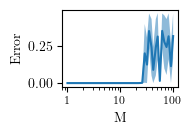

In [17]:
fig, ax = plt.subplots(figsize=(1.5, 1))
ax.plot(ms, errors_mean)
ax.fill_between(ms, (errors_mean - errors_std).clip(0, None), errors_mean + errors_std, alpha=.5)
ax.set_xscale('log')
ax.set_xlabel('M', fontsize=10)
ax.set_ylabel(r'Error', fontsize=10)
# ax.set_yticks([0, .02])
# ax.set_yticklabels([0, .02], fontsize=8)
ax.set_xticks([1, 10, 100])
ax.set_xticklabels([1, 10, 100], fontsize=8)
fig.savefig("error_m.pdf", bbox_inches='tight')

# ax.set_yscale('log')

In [5]:
m = 5
assoc = AssMem(d, n, m)
opti = th.optim.Adam(assoc.parameters(), lr=1e-3)

all_y = modular_class(all_x, m)

# number of data
batch_size = 1000
nb_epoch = 10000
T = nb_epoch * batch_size

for i in range(nb_epoch):
    x = th.multinomial(proba, batch_size, replacement=True)
    y = x % m

    opti.zero_grad()
    softpred = assoc(x)
    loss = - th.log(softpred[th.arange(len(y)), y]).mean()
    loss.backward()
    opti.step()

In [6]:
U = assoc.UT.detach().numpy()
X, Y = np.meshgrid(np.linspace(-1,1, num=100), np.linspace(-1, 1, num=100))
x = np.stack((X.flatten(), Y.flatten())).T
Z = np.argmax(x @ U, axis=1).reshape(X.shape)

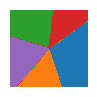

In [14]:
fig, ax = plt.subplots(figsize=(1,1))
ax.contourf(X, Y, Z, cmap='tab10', vmin=-.5, vmax=9.5)
ax.set_axis_off()
fig.savefig("output_embeddings.pdf")

In [11]:
mean_emb = th.zeros(m, 2)
std_emb = th.zeros(m, 2)
for i in range(m):
    E = assoc.E[all_y == i]
    mean_emb[i] = E.mean(dim=0)
    std_emb[i] = E.std(dim=0)

mean_emb = mean_emb.detach().numpy()
std_emb = std_emb.detach().numpy()

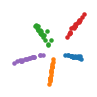

In [12]:
fig, ax = plt.subplots(figsize=(1,1))
# tmp = [3, 4, 0, 1, 2]
for i in range(m):
    emb = assoc.E[all_y == i].detach().numpy()
    # ax.scatter(emb[:, 0], emb[:, 1], s=5, c='C' + str(tmp[i]))
    ax.scatter(emb[:, 0], emb[:, 1], s=5)
ax.set_axis_off()
fig.savefig(f"input_embeddings_{m}.pdf")